# Timetree Analysis

1. Plot root-to-tip regression with date (tips).
1. Estimate a time-scaled phylogeny.
1. Plot root-to-tip regression with date (tips+internals)
1. Plot timetree.


**TO-DO**:

* [x] Identify if the local branch_length change is significant.  
    Conclusion: IT IS NOT!


    ```python
    # Line 403 of the treeanc.py file
    # self.tree.root.branch_length = 0.001
    self.tree.root.branch_length = self.tree.root.branch_length
    ```
    
* [x] Fix up some plotting parameters.  
    - Add the Low Confidence legend element
    - Remove y ticks
  
* [x] Add stats to the dataframe including:
    - date
    - date confidence
    - timetree x and y coordinates (to plot nodes)
    
* [x] Side by side divtree and timetree

* [x] Plot subtrees
    - Second pandemic
    - First pandemic
    
1. Refine timetree parameters, specifically:
    - Relaxed clock
    - Marginal date estimation and confidence

In [28]:
import treetime
import matplotlib.pyplot as plt
from matplotlib import patches, lines, gridspec
from Bio import Phylo, AlignIO
import os
import numpy as np
import pandas as pd
import random
import math
import copy
import scipy
import augur

pd.set_option("display.max_rows", None, "display.max_columns", None)
#pd.set_option("display.max_rows", 10, "display.max_columns", 10)
random.seed(1152342, 2)

tree_path = "../../docs/results/latest/branch_support/branch_support.nwk"
metadata_path = "../../docs/results/latest/mugration/mugration.tsv"
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"
constant_sites_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.full.constant_sites.txt"
outdir = "../../docs/results/latest/timetree/"

BRANCH_LEN_SIG_DIG = 12

# Font
SM_FONT = 5
MED_FONT = 8
LG_FONT = 10

figsize_alt=(9.6,4.8)
figsize_alt2=(4,4)

plt.rc('font', size=SM_FONT)          # controls default text sizes
plt.rc('figure', titlesize=LG_FONT)  # fontsize of the figure title
plt.rc('legend', title_fontsize=MED_FONT)  # fontsize of the legend title
plt.rc('legend', frameon=False)  # legend frame
plt.rc('axes', labelsize=MED_FONT)    # fontsize of the x and y labels
plt.rc('axes', titlesize=LG_FONT) # fontsize of axis titles
plt.rc('lines', linewidth=2)
plt.rc('legend', labelspacing=0.75)
dpi = 400

NO_DATA_CHAR = "NA"
DATE_COL = "Date"
TERM_COL = "grey"
#NAME_COL = "Sample"
NAME_COL = "Name"
REF_DATE = 1992.0
REF_LEN = 4653728
CONFIDENCE=0.95
N_IQD=3

COLOR_PAL = "tab10"
CMAP_N = 10
cmap = plt.get_cmap(COLOR_PAL, CMAP_N)
cmaplist = [cmap(i) for i in range(cmap.N)]

MUG_ATTR = "Branch_Major"

SCRIPT_NAME = "timetree"

In [2]:
# Manually set the seed
np.random.seed(70262122)
# randomly initialize the RNG from some platform-dependent source of entropy
#np.random.seed(None)

# get the initial state of the RNG
st0 = np.random.get_state()

# draw some random numbers
print(np.random.randint(0, 100, 10))               

[55 41  3  0 32 48 34 64 53 49]


## Functions

In [3]:
# This code is from the biopython Phylo module

def get_x_positions(tree):
    """
    Create a mapping of each clade to its horizontal position.
    Dict of {clade: x-coord}
    """
    depths = tree.depths()
    # If there are no branch lengths, assume unit branch lengths
    if not max(depths.values()):
        depths = tree.depths(unit_branch_lengths=True)
    return depths

def get_y_positions(tree):
    """
    Create a mapping of each clade to its vertical position.
    Dict of {clade: y-coord}.
    Coordinates are negative, and integers for tips.
    """
    maxheight = tree.count_terminals()
    # Rows are defined by the tips
    heights = {
        tip: maxheight - i for i, tip in enumerate(reversed(tree.get_terminals()))
    }

    # Internal nodes: place at midpoint of children
    def calc_row(clade):
        for subclade in clade:
            if subclade not in heights:
                calc_row(subclade)
        # Closure over heights
        heights[clade] = (
            heights[clade.clades[0]] + heights[clade.clades[-1]]
        ) / 2.0

    if tree.root.clades:
        calc_row(tree.root)
    return heights

def convert_timetree_ticks(tree, step):
    """
    Return a dict of axis locations and labels for an input timetree tree.
    """
    # Step 1: Figure out offset to convert year branch length to calendar date
    min_date = tree.root.numdate - tree.root.branch_length
    max_date = np.max([n.numdate for n in tree.get_terminals()])
    offset = min_date
    date_range = np.max([n.numdate for n in tree.get_terminals()]) - min_date

    # Step 2: Relabel xticks and space them differently
    # Distance between ticks
    dtick = step
    # Minimum tick value
    min_tick = step*(offset//step)

    # Extra tick increment
    extra = dtick if dtick<date_range else dtick
    # New tick values
    tick_vals = np.arange(min_tick, min_tick+date_range+extra, dtick)
    # New tick locations
    tick_locs = tick_vals - offset
    # New tick labels
    tick_labels = ["%d"%(int(x)) for x in tick_vals]
    return {"tick_locs": tick_locs, "tick_labels": tick_labels}

### Add constant sites to the snp alignment
MEMORY PERMMITING!

In [4]:
align = AlignIO.read(aln_path, format="fasta")

In [ ]:
"""constant_sites_dict = {"A": 0, "C" : 0, "G" : 0, "T" : 0}

with open(constant_sites_path, "r") as infile:
    constant_sites_list = infile.read().strip().split(",")
    constant_sites_dict["A"] = int(constant_sites_list[0])
    constant_sites_dict["C"] = int(constant_sites_list[1])
    constant_sites_dict["G"] = int(constant_sites_list[2])
    constant_sites_dict["T"] = int(constant_sites_list[3])    

print(constant_sites_dict)
total_constant_sites = sum(constant_sites_dict.values())
print("Constant Sites:", total_constant_sites)

# Add the constant sites to each sample
# Iterate through each samples sequence
for rec in align:
    # Iterate through each nucleotide for constant sites
    for nucleotide,count in constant_sites_dict.items():
        rec.seq = rec.seq + (nucleotide * count)   """   

### Create a basic TimeTree Object

In [32]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(metadata_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v

# Add the reference date
dates["Reference"] = REF_DATE

# Construct the treetime object
# Remember, including the alignment is crucial!
tt = treetime.TreeTime(dates=dates, 
                       aln=align,                     
                       tree=tree_path, 
                       verbose=4, 
                       fill_overhangs=False,
                       seq_len=REF_LEN,                        
                      )

# Remove outliers
tt.clock_filter(reroot=None, 
                n_iqd=N_IQD, 
                plot=False,
               )

# Check rtt
print(tt.date2dist.__dict__)


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.

0.00	-TreeAnc: set-up

0.48	-SequenceData: loaded alignment.
0.48	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

0.48	-SeqData: making compressed alignment...

2.02	-SequenceData: constructed compressed alignment...
2.19	--ClockTree: Setting precision to level 2

2.22	-ClockTree._assign_dates: assigned date contraints to 523 out of 523 tips.
2.33	--ClockTree.date2dist: Setting new molecular clock. rate=9.668e-09,
    	  R^2=0.2481
{'clock_rate': 9.668191437748236e-09, 'intercept': 5.1466761659175907e-05, 'chisq': 2.4482378587650225e-08, 'r_val': 0.4980791900560189, 'cov': None, 'sigma': 0, 'valid_confidence': False}


### Run Clock Analysis

In [33]:
# PARAM SET 1: root='-4101-09-02'
# tt.run()

# PARAM SET 2 date='-4113-02-20'
# tt.run(resolve_polytomies=False)

# PARAM SET 3 date='-4026-06-22'
# Skyline needs max_iter set (Above 1?)
# tt.run(resolve_polytomies=False, Tc="skyline", max_iter=3)

# PARAM SET X date='-4033-07-16'
tt.run(resolve_polytomies=False, 
       Tc="skyline", 
       max_iter=3,
       relaxed_clock={"slack":1.0, "coupling": 0}
       )

# PARAM SET X
# Resolve polytomies might be problematic, nodes are being deleted and recreated.
# This may affect my node dataframe
#tt.run(root=None, infer_gtr=True, relaxed_clock=False, max_iter=1,
#                    branch_length_mode='input', n_iqd=3, resolve_polytomies=False,
#                    Tc='skyline', time_marginal="assign", vary_rate=True)

# PARAM SET X date='-19904-12-03'
"""
tt.run(branch_length_mode = "input",
               n_iqd=3,
               root=None,
               infer_gtr=True,
               resolve_polytomies=False,
               relaxed_clock={"slack":1.0, "coupling": 0},
               max_iter=3,
               Tc="skyline",
               use_covariation=False,
               vary_rate=False,
               time_marginal="assign",
               sequence_marginal=True,
               verbose=4,
              )
"""


4.58	-TreeTime._set_branch_length_mode: maximum branch length is 3.648e-05,
    	 using branch length mode joint

4.58	-TreeAnc.optimize_tree: sequences...

4.58	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint

4.58	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.
4.58	--TreeAnc._ml_anc_joint: type of reconstruction: Joint
4.58	---TreeAnc._ml_anc_joint: Walking up the tree, computing likelihoods...
8.27	---TreeAnc._ml_anc_joint: Walking down the tree, computing maximum
    	   likelihood sequences...
8.37	---TreeAnc._ml_anc_joint: ...done
8.38	--TreeAnc.infer_gtr: counting mutations...
9.23	---TreeAnc.infer_gtr: counting mutations...done

9.23	-GTR: wi

'\ntt.run(branch_length_mode = "input",\n               n_iqd=3,\n               root=None,\n               infer_gtr=True,\n               resolve_polytomies=False,\n               relaxed_clock={"slack":1.0, "coupling": 0},\n               max_iter=3,\n               Tc="skyline",\n               use_covariation=False,\n               vary_rate=False,\n               time_marginal="assign",\n               sequence_marginal=True,\n               verbose=4,\n              )\n'

In [34]:
# Quick check
tt.tree.common_ancestor("NODE0")

Clade(_v=0, bad_branch=False, branch_length=0.001, clock_length=0.001, date='-4033-07-16', dist2root=0.0, mutation_length=0.001, name='NODE0', original_length=0.0)

### Save Stats

In [35]:
print(tt.gtr)
out_path_gtr = os.path.join(outdir, SCRIPT_NAME + "_gtr.txt" )
with open(out_path_gtr, 'w', encoding='utf-8') as outfile:
    outfile.write(str(tt.gtr)+'\n')

print(tt.date2dist)
out_path_gtr = os.path.join(outdir, SCRIPT_NAME + "_clock.txt" )
with open(out_path_gtr, 'w', encoding='utf-8') as outfile:
    outfile.write(str(tt.date2dist)+'\n')

Substitution rate (mu): 1.0

Equilibrium frequencies (pi_i):
  A: 0.1932
  C: 0.3027
  G: 0.2865
  T: 0.2077
  -: 0.0099

Symmetrized rates from j->i (W_ij):
	A	C	G	T	-
  A	0	0.3109	0.3673	0.1757	72.0396
  C	0.3109	0	0.0473	0.3318	91.3216
  G	0.3673	0.0473	0	0.3352	83.9392
  T	0.1757	0.3318	0.3352	0	77.3802
  -	72.0396	91.3216	83.9392	77.3802	0

Actual rates from j->i (Q_ij):
	A	C	G	T	-
  A	0	0.0601	0.071	0.0339	13.9186
  C	0.0941	0	0.0143	0.1004	27.6446
  G	0.1052	0.0135	0	0.096	24.0449
  T	0.0365	0.0689	0.0696	0	16.0728
  -	0.7136	0.9047	0.8315	0.7665	0

Root-Tip-Regression:
 --rate:	8.956e-09
 --r^2:  	0.26



### Add timetree info to dataframe

In [36]:
tree_df = pd.read_csv(metadata_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index(NAME_COL, inplace=True)

# make a copy of the tree
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()
tt_copy.tree.ladderize(reverse=True)

x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)
tt_reg = tt_copy.setup_TreeRegression()

# Create new columns
tree_df["timetree_" + DATE_COL] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))] 
tree_df["timetree_reg_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_bad"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Add x and y coordinates
for c in tt_copy.tree.find_clades():
    # Remove the mysterious NODE_ nodes
    if not c.name or "NODE_" in c.name: continue
        
    # Add dates and confidence
    tree_df.at[c.name, "timetree_" + DATE_COL] = c.numdate
    #conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
    #tree_df.at[c.name, "timetree_" + DATE_COL] = conf
    
    # Scatter coordinates
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    tree_df.at[c.name, 'timetree_coord_x'] = coord_x
    tree_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    # Regression
    reg_y = c._v
    if c.is_terminal():
        reg_x = tt_reg.tip_value(c)
    else:
        reg_x = c.numdate
    reg_bad = c.bad_branch  if hasattr(c, 'bad_branch') else False
    tree_df.at[c.name, 'timetree_reg_x'] = reg_x
    tree_df.at[c.name, 'timetree_reg_y'] = reg_y    
    tree_df.at[c.name, 'timetree_reg_bad'] = reg_bad
    
tree_df

482.47	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years


UFboot  aLRT  \
Name                                                              
NODE0                                                 100   100   
NODE1                                                 100  99.9   
NODE2                                                 100   100   
NODE3                                                 100   100   
NODE4                                                 100  97.9   
NODE5                                                 100   100   
NODE6                                                 100  98.9   
NODE7                                                 100   100   
NODE8                                                 100  98.4   
NODE9                                                 100  96.3   
NODE10                                                 81     0   
NODE11                                                100    73   
NODE12                                                100    79   
NODE13                                                 24     0   
NODE14                                                100  91.4   
NODE15                                                 83     0   
NODE16                                                 79  31.2   
NODE17                                                100  99.4   
NODE18                                                100  99.7   
NODE19                                                100    86   
NODE20                                                 24     0   
NODE21                                                 13     0   
NODE22                                                100  89.8   
NODE23                                                100  74.1   
NODE24                                                100   100   
NODE25                                                 25     0   
NODE26                                                 11     0   
NODE27                                                 11     0   
NODE28                                                100  94.8   
NODE29                                                 13     0   
NODE30                                                 56     0   
NODE31                                                100  75.2   
NODE32                                                100   100   
NODE33                                                 99  93.7   
NODE34                                                  5  91.1   
NODE35                                                  2     0   
NODE36                                                  3     0   
NODE37                                                  4  92.7   
NODE38                                                 11     0   
NODE39                                                  9     0   
NODE40                                                  0     0   
NODE41                                                 11     0   
NODE42                                                 12     0   
NODE43                                                  4     0   
NODE44                                                 12  44.3   
NODE45                                                  5     0   
NODE46                                                 11     0   
NODE47                                                 11     0   
NODE48                                                  9     0   
GCA_000269265.1_ASM26926v1_genomic                     NA    NA   
GCA_000269385.1_ASM26938v1_genomic                     NA    NA   
NODE51                                                100  97.9   
GCA_000269285.1_ASM26928v1_genomic                     NA    NA   
GCA_000269285.2_ASM26928v2_genomic                     NA    NA   
NODE54                                                 11     0   
NODE55                                                 99  82.6   
GCA_000268945.1_ASM26894v1_genomic                     NA    NA   
GCA_000269105.1_ASM26910v1_genomic                     NA    NA   
GCA_000269125.1_ASM26912v1_geno

## Root To Tip Regression

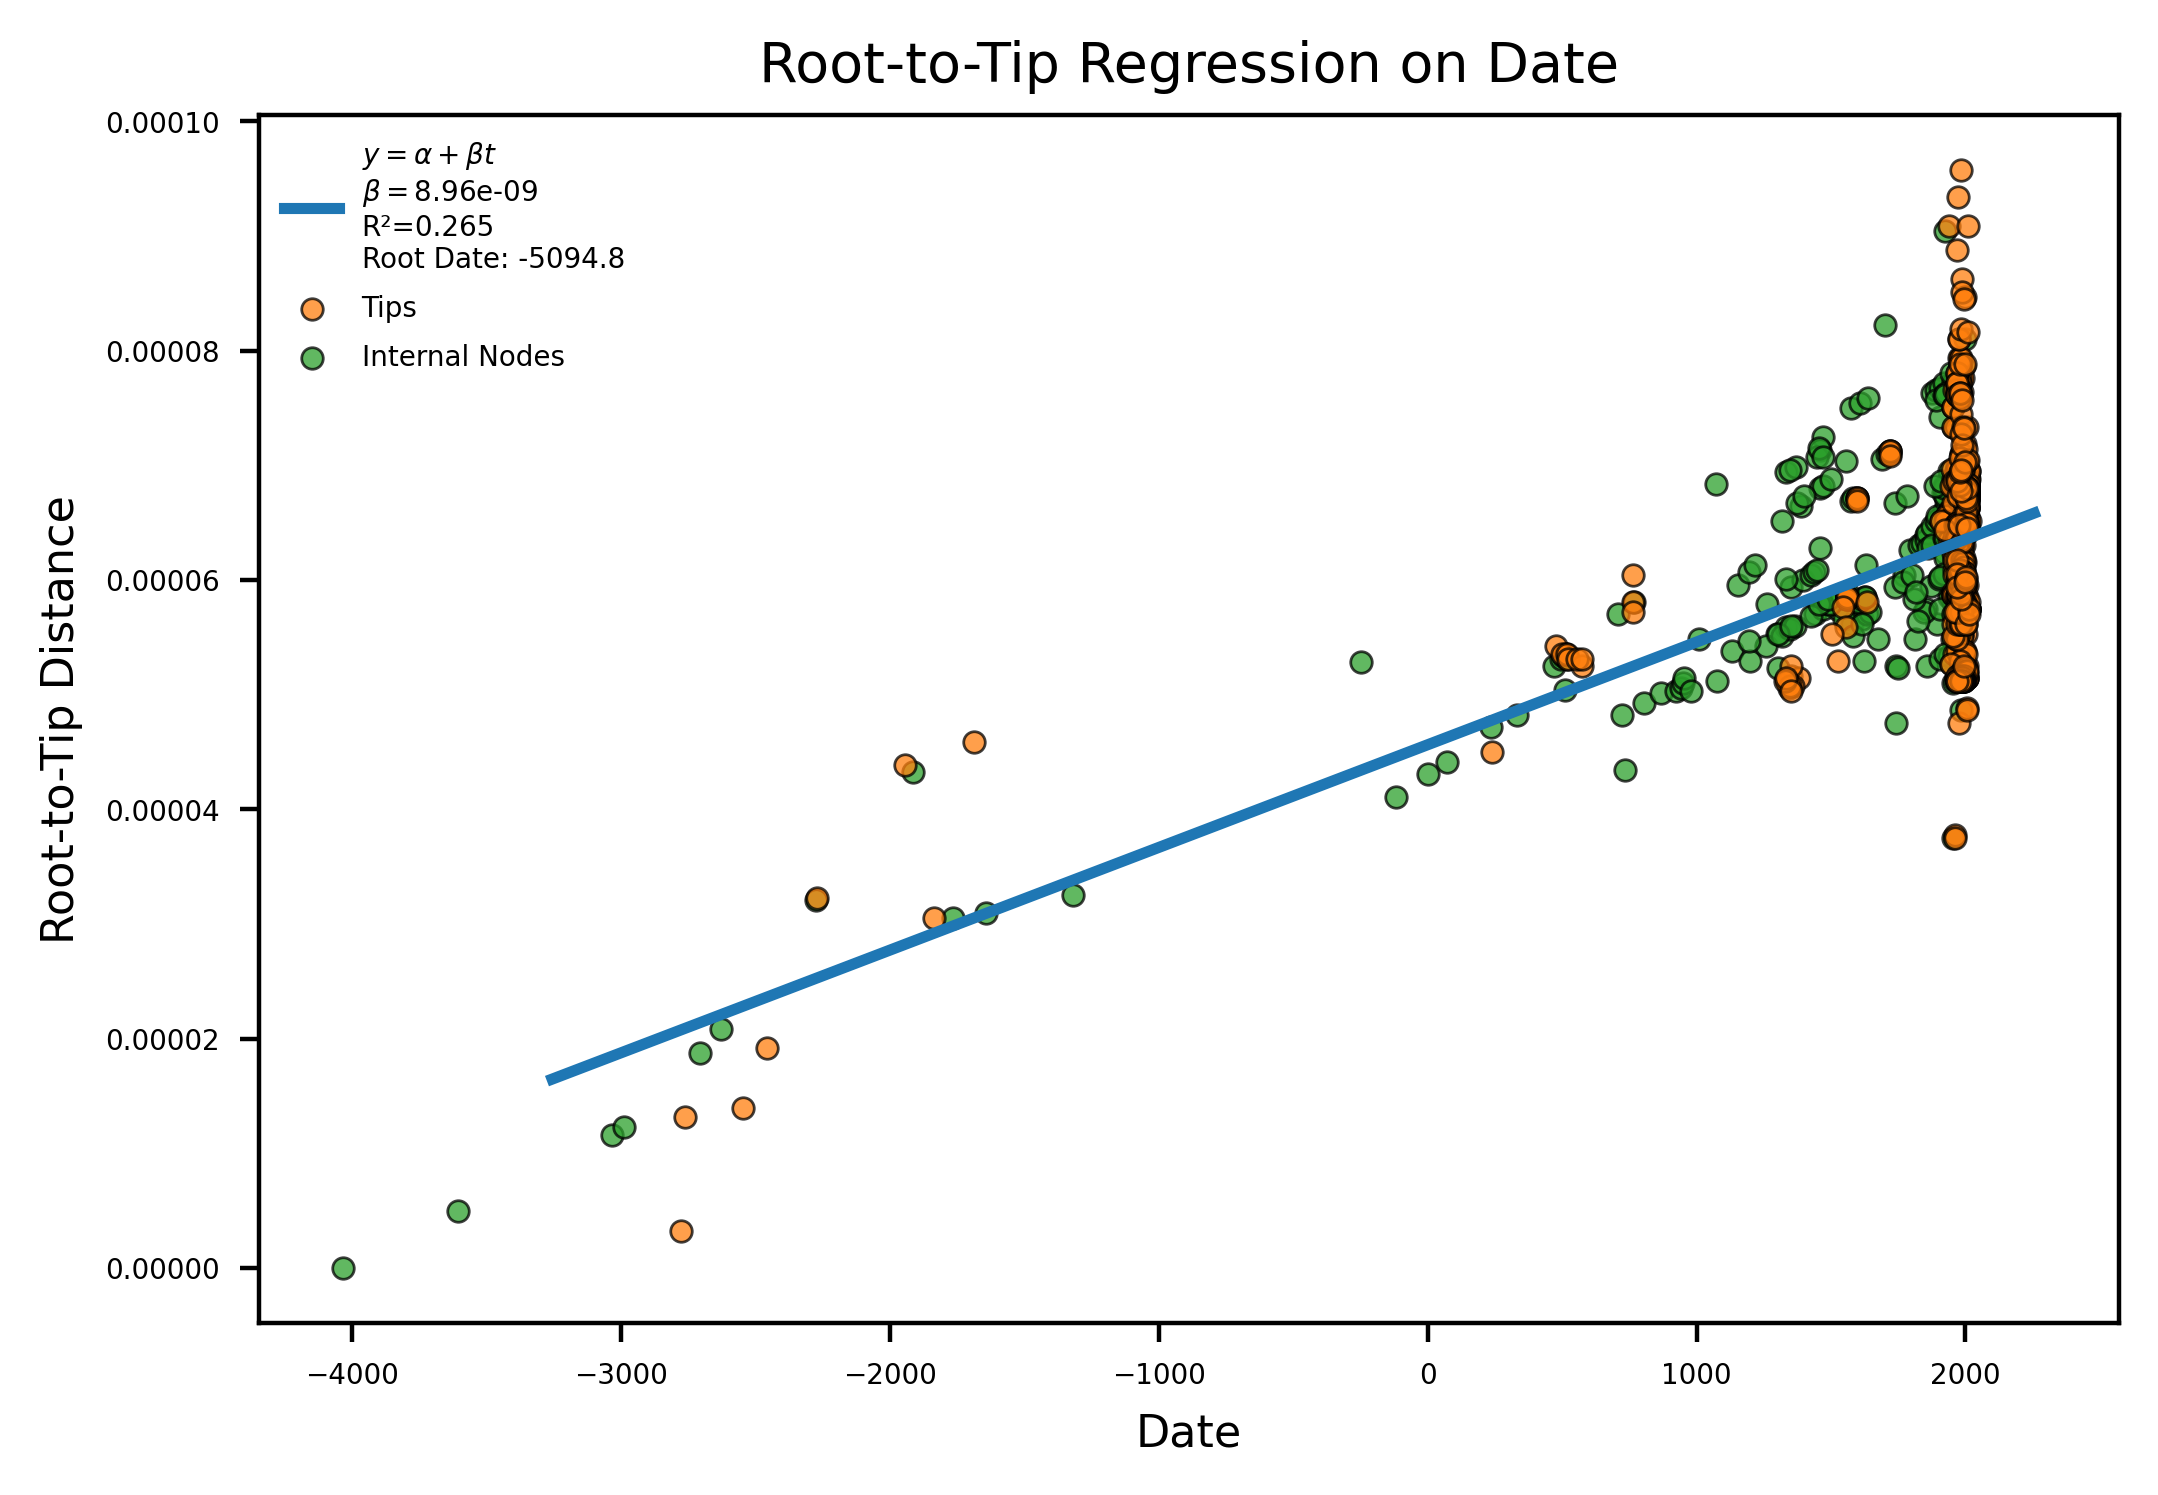

In [37]:
# Root to tip regression
fig, (ax1) = plt.subplots(1, dpi=400)

tip_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) & (tree_df["Branch_Support_Color"] == TERM_COL)]
int_data = tree_df[(tree_df["timetree_reg_x"] != NO_DATA_CHAR) & (tree_df["Branch_Support_Color"] != TERM_COL)]
regression = tt.clock_model
t_mrca = -regression['intercept']/regression['slope']
# This does not filter for bad branches!
time_span = np.max(tip_data["timetree_reg_x"]) - np.min(tip_data["timetree_reg_x"])
x_vals = np.array([max(np.min(tip_data["timetree_reg_x"]), t_mrca) - 0.1*time_span, 
                   np.max(tip_data["timetree_reg_x"]+0.05*time_span)])

res = scipy.stats.linregress(list(tip_data["timetree_reg_x"]),list(tip_data["timetree_reg_y"]))

# When no confidence is enabled
dev_rtt = None
dev_slope = None

# Plot tips
ax1.scatter(data=tip_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Tips",
            color=cmaplist[1],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=2,)

# Plot internal nodes
ax1.scatter(data=int_data, 
            x="timetree_reg_x", 
            y="timetree_reg_y",
            label="Internal Nodes",
            color=cmaplist[2],
            edgecolor="black",
            linewidth=0.5,
            s=15,
            alpha=0.75,
            zorder=1,)

# Regression line
ax1.plot(x_vals, 
         regression['slope']*x_vals + regression['intercept'],
         label = r"$y=\alpha + \beta t$"+"\n"+
                r"$\beta=$%1.2e"%(regression["slope"])
                + ("+/- %1.e"%dev_slope if dev_slope else "") +
                "\nR²={:.3f}".format(res.rvalue**2) +
                "\nRoot Date: %1.1f"%(-regression['intercept']/regression['slope']) +
                ("+/- %1.2f"%dev_rtt if dev_rtt else ""),
         color=cmaplist[0],
        )

# Labels
ax1.set_xlabel("Date")
ax1.set_ylabel("Root-to-Tip Distance")
ax1.set_title("Root-to-Tip Regression on Date")
# Legend
plt.legend(loc=2)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt.jpg") 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

---
# Plot Trees

### Events of import

In [51]:
tt_copy = copy.deepcopy(tt)
tt_copy.tree.ladderize(reverse=True)
black_death_node = tt_copy.tree.common_ancestor("SAMN00715800") # black death node: 8291
justinian_plague_node = tt_copy.tree.common_ancestor("SAMEA4354665") #justinian plague node: AE1175 
first_pandemic_mrca =  tt_copy.tree.common_ancestor("SAMEA4354665", "SAMEA1061800") # AE1175, DA101
second_pandemic_mrca = tt_copy.tree.common_ancestor("SAMN00715800","SAMEA3713715", "SAMEA5818822") # 8291, OBS137, STN008
third_pandemic_tips = list(tree_df[(tree_df["Branch_Major"] == "1.ORI")].index)
third_pandemic_mrca = tt_copy.tree.common_ancestor(third_pandemic_tips)

target_attr = {"2.ANT": '', "2.MED": '', "3.ANT": "", "4.ANT": ""}
for c in tt_copy.tree.get_terminals():
    mug_val = tree_df[MUG_ATTR][c.name]
    if mug_val in target_attr and not target_attr[mug_val]:
        target_attr[mug_val] = c
        
big_bang_node = tt_copy.tree.common_ancestor(list(target_attr.values()))

### Import the divergence tree

In [39]:
tree_div = Phylo.read(tree_path, "newick")
tree_div.ladderize(reverse=False)
#Phylo.draw(tree_div)

## Color Clades

Using a mugration attribute (example major branch)

div tree then time tree

In [40]:
for c in tree_div.find_clades():
    # Remove the mysterious NODE_ nodes
    if not c.name or "NODE_" in c.name: continue   
    mug_val = tree_df["Mugration_" + MUG_ATTR][c.name]
    mug_color = tree_df["Mugration_" + MUG_ATTR + "_Color"][c.name]
    c.color = mug_color

In [41]:
# Color branches by a mugration attribute
mug_dict = {MUG_ATTR: {"hex_color": {}}}

# Deepest nodes first 
tt.tree.ladderize(reverse=False)  

# Change the branch color based on a mugration attribute
for c in tt.tree.find_clades():
    # Remove the mysterious NODE_ nodes
    if not c.name or "NODE_" in c.name: continue   
    mug_val = tree_df["Mugration_" + MUG_ATTR][c.name]
    mug_color = tree_df["Mugration_" + MUG_ATTR + "_Color"][c.name]
    # If it's not an nan
    if not pd.isnull(mug_color):
        c.color = mug_color
    if not pd.isnull(mug_val) and c.is_terminal():
        mug_dict[MUG_ATTR]["hex_color"][mug_val] = mug_color

# Add low confidence color
mug_dict[MUG_ATTR]["hex_color"]["Low Confidence"] = "grey"

### Plot Full Timetree

635.29	--ClockTree.branch_length_to_years: setting node positions in units of
      	  years


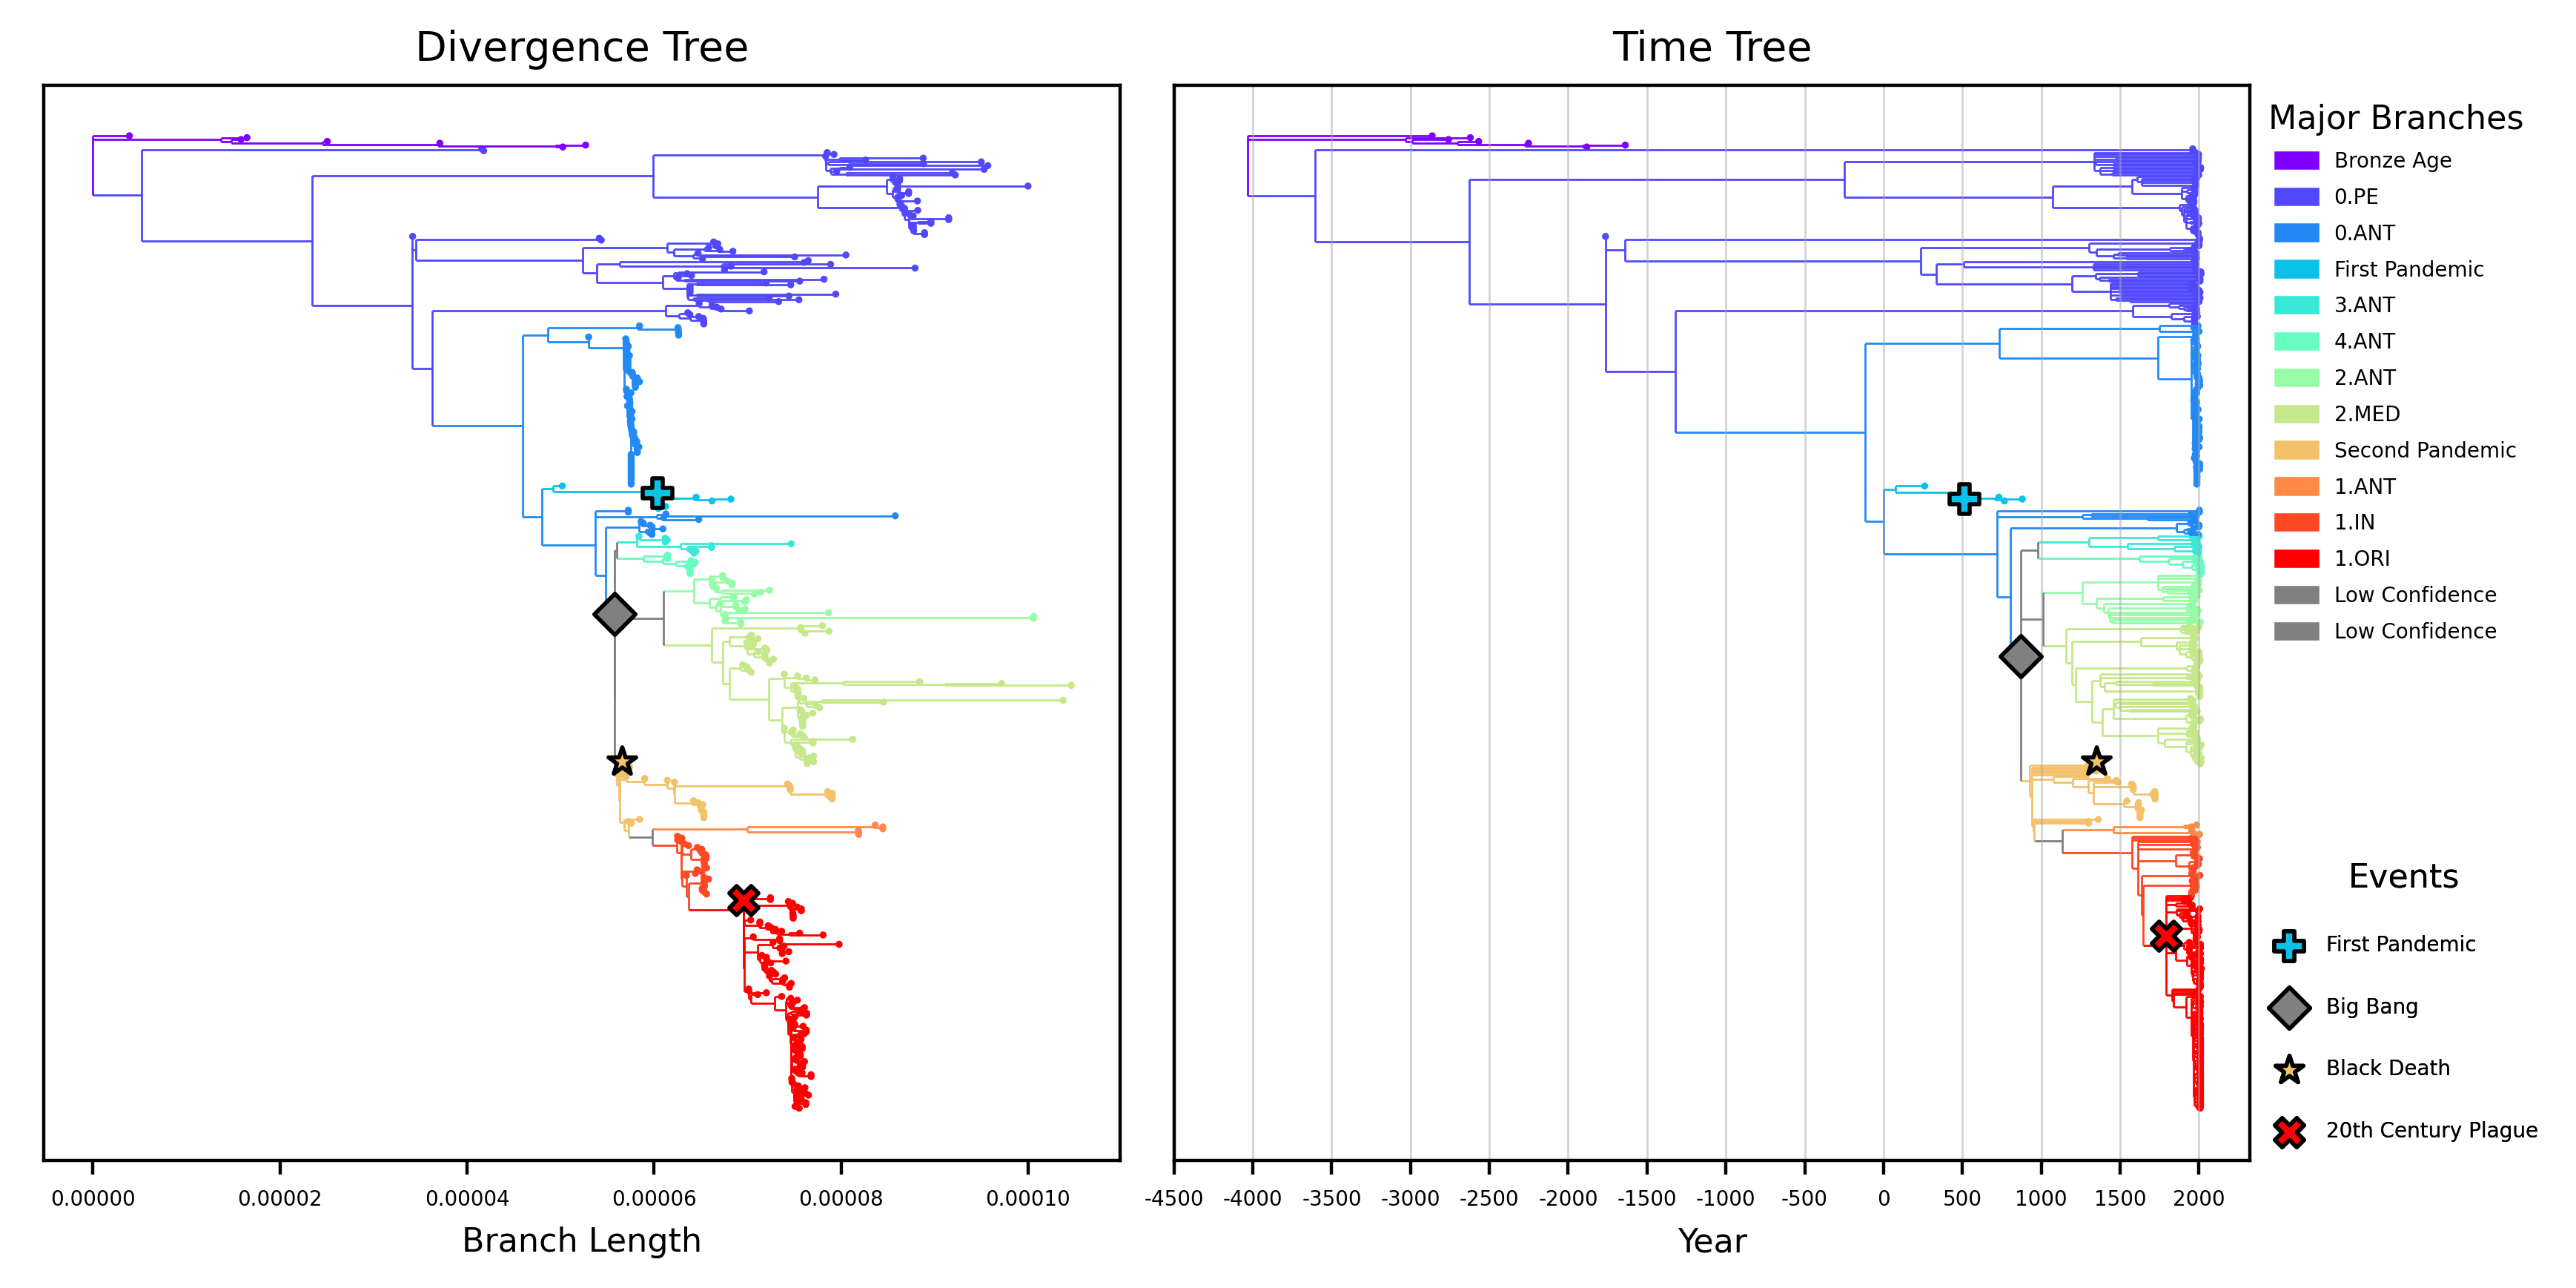

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, 
                         dpi=dpi, 
                         gridspec_kw={'wspace': 0.05}, 
                         figsize=figsize_alt,
                         sharey=True,
                         )

plt.rc('lines', linewidth=0.5)
# --------------------------------------------
# Draw trees
tt.branch_length_to_years()
for t,ax in zip([tree_div, tt.tree], [ax1, ax2]):
    t.ladderize(reverse=True)
    Phylo.draw(t, 
           axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)
# --------------------------------------------
# Draw tips
tip_div_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL)]
tip_time_data = tree_df[(tree_df["Branch_Support_Color"] == TERM_COL) & (tree_df["timetree_coord_x"] != NO_DATA_CHAR)]
for df,ax,prefix in zip([tip_div_data, tip_time_data], [ax1, ax2], ["coord_", "timetree_coord_"]):
    ax.scatter(data=df,
               x=prefix + "x", 
               y=prefix + "y",
               s=0.5, 
               c="Mugration_" + MUG_ATTR + "_Color",
               label="",)

# --------------------------------------------
# Draw events
event_marker_size = 50
event_dict = {
    "First Pandemic": {
        "node": justinian_plague_node,
        "marker": "P",
        "color": mug_dict[MUG_ATTR]["hex_color"]["First Pandemic"],
    }, 
    "Big Bang": {
        "node": big_bang_node,
        "marker": "D",
        "color": mug_dict[MUG_ATTR]["hex_color"]["Low Confidence"],
    },
    "Black Death" : {
        "node": black_death_node,
        "marker": "*",
        "color": mug_dict[MUG_ATTR]["hex_color"]["Second Pandemic"],
    },
    "20th Century Plague": {
        "node" : third_pandemic_mrca,
        "marker" : "X",
        "color": mug_dict[MUG_ATTR]["hex_color"]["1.ORI"],
    }}

for event in event_dict:
    # shift markers up
    y_shift = 5
    # plot on both axes
    ax1.scatter(
        x = tree_df["coord_x"][event_dict[event]["node"].name], 
        y = tree_df["coord_y"][event_dict[event]["node"].name] + y_shift,
        marker=event_dict[event]["marker"], 
        label=event, 
        color=event_dict[event]["color"], 
        ec="black",
        s=event_marker_size,
        zorder=3,
        )    
    ax2.scatter(
        x = tree_df["timetree_coord_x"][event_dict[event]["node"].name], 
        y = tree_df["timetree_coord_y"][event_dict[event]["node"].name] + y_shift,
        marker=event_dict[event]["marker"], 
        label=event, 
        color=event_dict[event]["color"], 
        ec="black",
        s=event_marker_size,
        zorder=3,
        )

# --------------------------------------------
# Labels

ax1.set_xlabel('Branch Length')
ax1.set_ylabel('')    

ax2.set_xlabel('Year')
ax2.set_ylabel('')

ax1.set_title("Divergence Tree")
ax2.set_title("Time Tree")

# --------------------------------------------
# Ticks

# The y axis is not particularly meaning, remove the ticks
ax1.set_yticks([])
ax2.set_yticks([])

ticks_dict = convert_timetree_ticks(tree=t, step=500)

# Set the new tick locations and labels
ax2.set_xticks(ticks_dict["tick_locs"])
ax2.set_xticklabels(ticks_dict["tick_labels"])

# --------------------------------------------
# Lines

# Vertical lines for dates
for loc in ticks_dict["tick_locs"]:
    ax2.axvline(x=loc, color="darkgrey", alpha=0.5)

# --------------------------------------------
# Limits

x_buffer = max(tree_df["coord_x"]) * 0.05
y_buffer = math.ceil(len(tree_div.get_terminals()) * 0.01)

ax1.set_xlim(0 - x_buffer, max(tree_df["coord_x"]) + x_buffer)
ax1.set_ylim(0 - y_buffer,len(tree_div.get_terminals()) + y_buffer)

x_buffer = math.ceil((ticks_dict["tick_locs"][-1] - ticks_dict["tick_locs"][0]) * 0.05)
y_buffer = math.ceil(len(tt.tree.get_terminals()) * 0.05)

# No x buffer on lower end
ax2.set_xlim(ticks_dict["tick_locs"][0], ticks_dict["tick_locs"][-1] + x_buffer)
ax2.set_ylim(0 - y_buffer,len(tt.tree.get_terminals()) + y_buffer)

# --------------------------------------------
# Legends

# Make a custom patches legend for the mugration attribute
legend_mug_elements = [patches.Patch(facecolor=value, edgecolor=value,) for value in mug_dict[MUG_ATTR]["hex_color"].values()]
legend_mug_labels = list(mug_dict[MUG_ATTR]["hex_color"].keys())
# Add low confidence
legend_mug_elements += [patches.Patch(facecolor="grey", edgecolor="grey",)]
legend_mug_labels += ["Low Confidence"]

legend_mug = ax2.legend(legend_mug_elements, 
           legend_mug_labels, 
           bbox_to_anchor=(1.0, 1.0), 
           loc='upper left', 
           title="Major Branches",)

legend_events = ax2.legend(bbox_to_anchor=(1.0, 0.00), 
           loc='lower left',
           title="Events",
           labelspacing=2,)

# Add multiple legends as artists
ax2.add_artist(legend_mug)
ax2.add_artist(legend_events)

# --------------------------------------------
# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_divtree_{}.jpg".format(MUG_ATTR.lower()))  
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

### Date Conversion

## Black Death / Second Pandemic

I want this to be a subtree that starts at the common ancestor of all the "Second Pandemic" strains. I also want to be able to collapse/prune(?) the clades that come after the Second Pandemic: 1.ANT, 1.IN, 1.ORI

CURRENTLY BROKEN!

Second Pandemic
['', '', '']


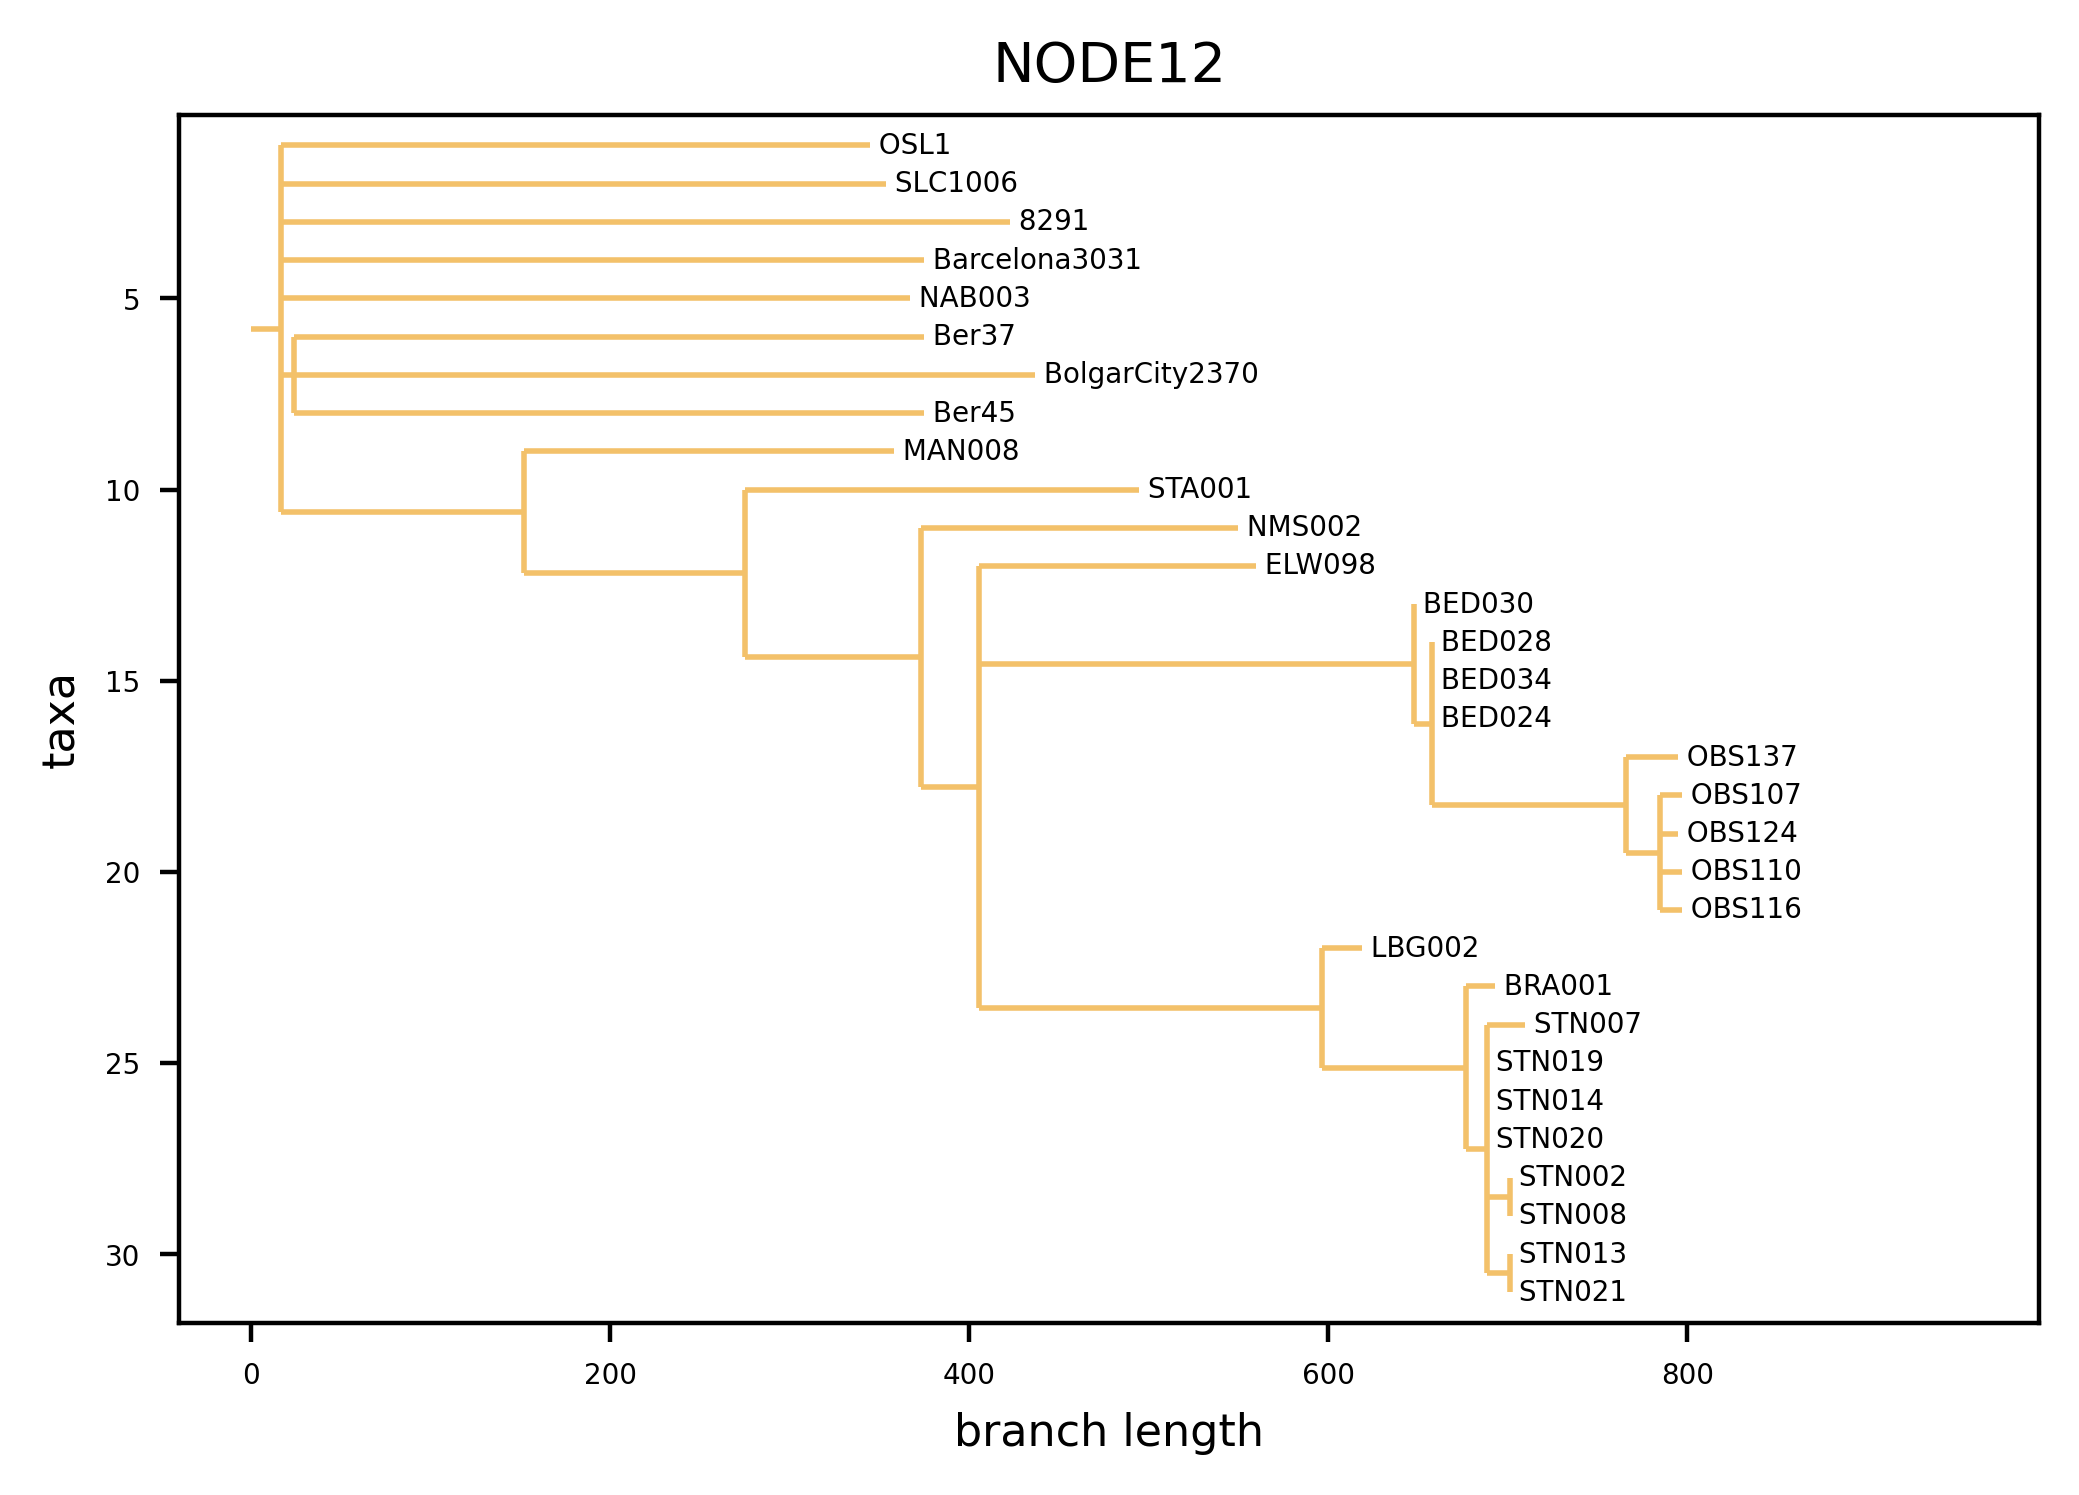

/opt/conda/envs/plague-phylogeography/lib/python3.7/site-packages/ipykernel_launcher.py:89: UserWarning: FixedFormatter should only be used together with FixedLocator


First Pandemic


<Figure size 432x288 with 0 Axes>

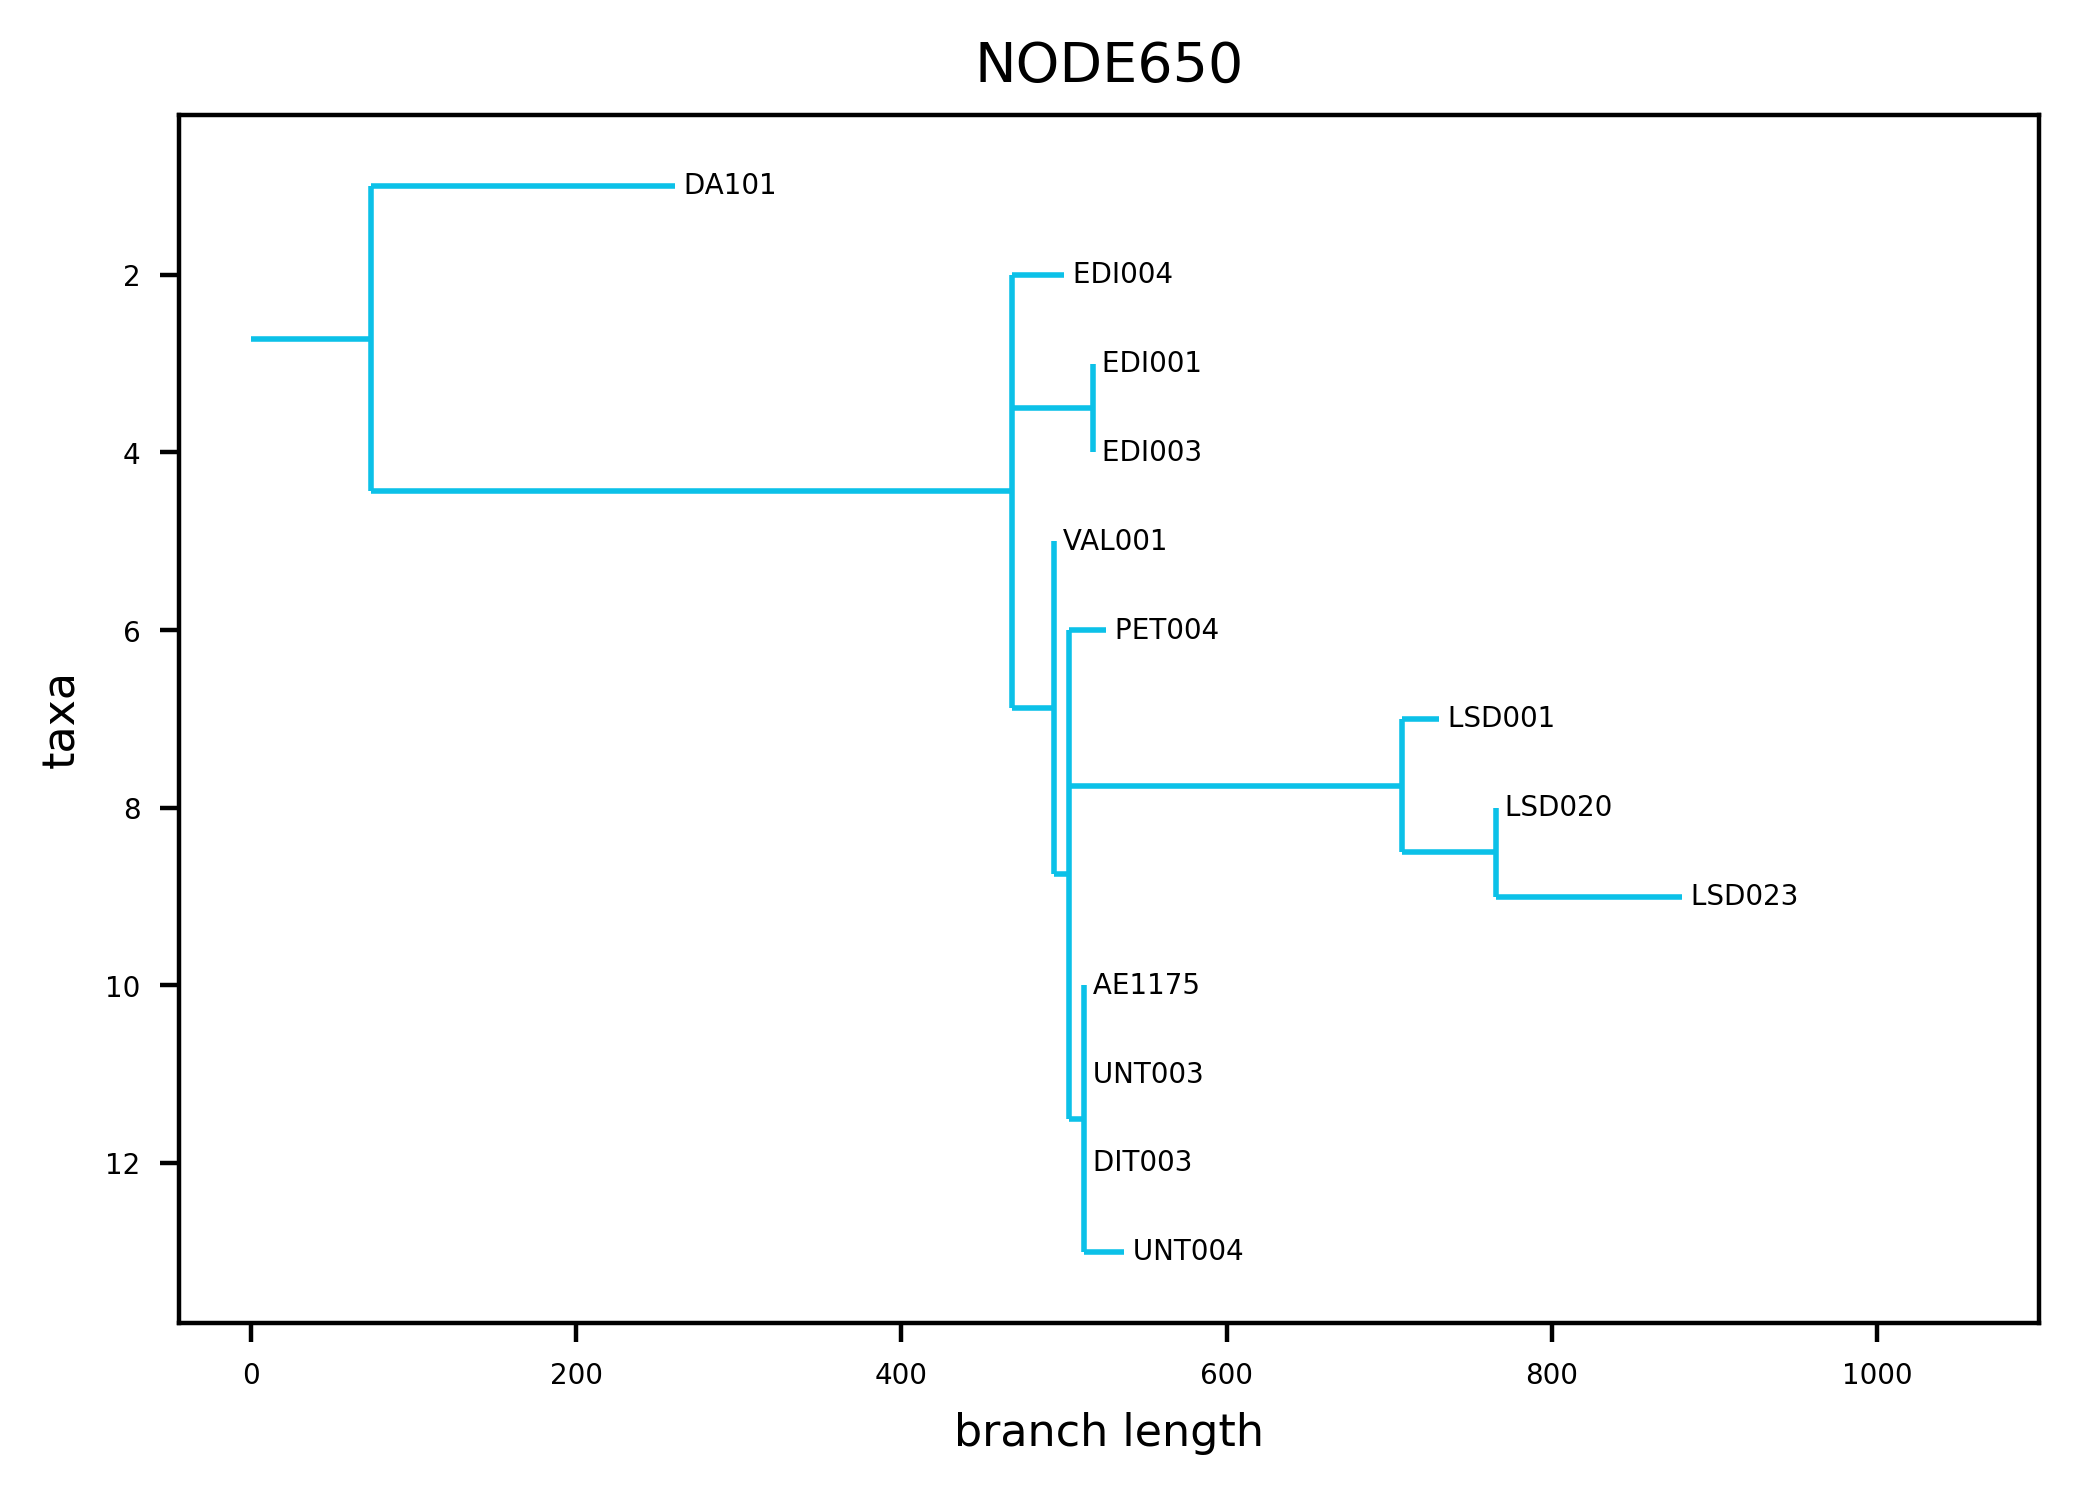

1.ORI


<Figure size 432x288 with 0 Axes>

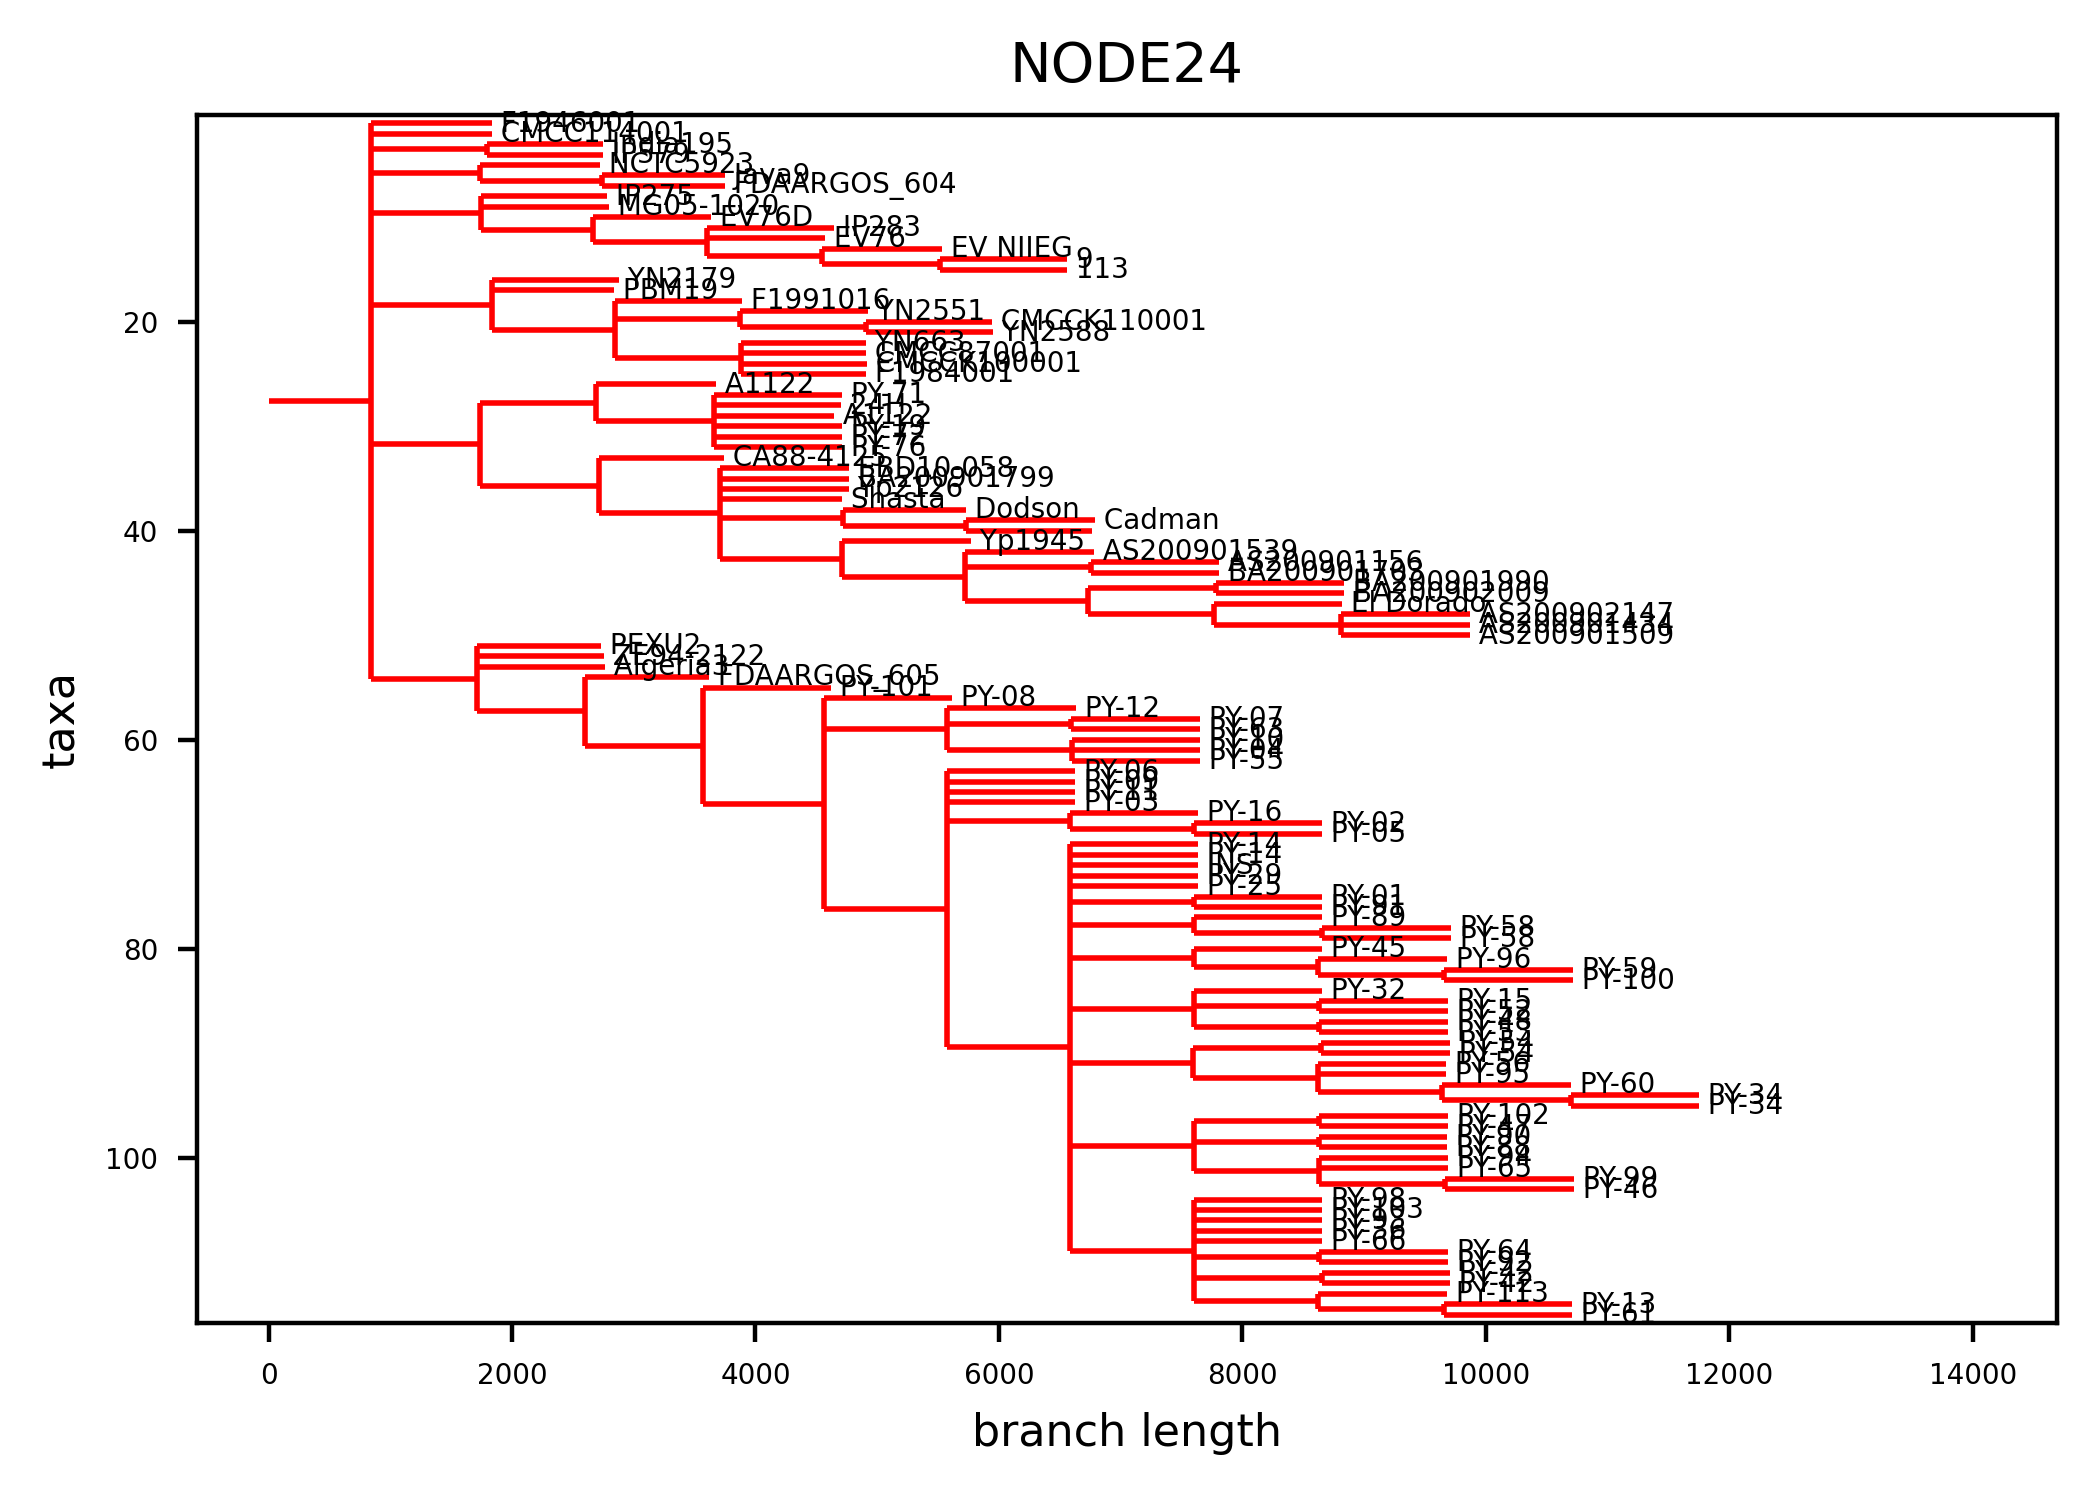

<Figure size 432x288 with 0 Axes>

In [56]:
subtree_dict = {
    "Second Pandemic" : {
        "tips": ["SAMN00715800","SAMEA3713715", "SAMEA5818822"], # 8291, OBS137, STN008
        "color": mug_dict[MUG_ATTR]["hex_color"]["Second Pandemic"],
        "node" : second_pandemic_mrca,
        "collapse": {"1.ORI": '', "1.IN": '', "1.ANT": ''},
        "step" : 50,
    },
    "First Pandemic" : {
        "tips": ["SAMEA4354665", "SAMEA1061800"], # AE1175, DA101
        "color": mug_dict[MUG_ATTR]["hex_color"]["First Pandemic"],
        "node" : first_pandemic_mrca,
        "collapse": {},
        "step" : 100,
    },  
    "1.ORI" : {
        "tips": ["Reference"],
        "color": mug_dict[MUG_ATTR]["hex_color"]["1.ORI"],
        "node" : third_pandemic_mrca,
        "collapse": {},
        "step" : 100,
    },      
}


for event_label in subtree_dict:
    print(event_label)
    tt_copy = copy.deepcopy(tt)
    #tt_copy.branch_length_to_years() 
    
    if not subtree_dict[event_label]["node"]:
        print("NO")
        subtree_dict[event_label]["node"] = tt_copy.tree.common_ancestor(subtree_dict[event_label]["tips"])
    t = subtree_dict[event_label]["node"]
    
    #fig = plt.figure(dpi=400)
    fig, ax1 = plt.subplots(1, dpi=400)
    
    
    # --------------------------------------------
    # Collapse Undesired Clades
    if len(subtree_dict[event_label]["collapse"].values()) > 0:     
        # Find the first tip that full fills the value criteria
        for c in t.get_terminals():
            mug_val = tree_df[MUG_ATTR][c.name]
            if mug_val in subtree_dict[event_label]["collapse"] and not subtree_dict[event_label]["collapse"][mug_val]:
                subtree_dict[event_label]["collapse"][mug_val] = c.name
        
        target_nodes =  list(subtree_dict[event_label]["collapse"].values())
        print(target_nodes)
        if len("".join(target_nodes)) > 0:
            collapse_node = t.common_ancestor(target_nodes)       
            # Collapse all clades
            for c in collapse_node.find_clades():
                t.collapse(target=c.name)
    
    # --------------------------------------------
    # Draw Tree
    plt.rc('lines', linewidth=1)
    t.ladderize(reverse=False)  
    label_func = lambda x: tree_df["Strain"][x.name] if tree_df["Strain"][x.name] != "NA" else ""
    #label_func = lambda x: x
    #label_func = lambda x: (
    #    "{} ({})".format(tree_df["Country"][x.name], tree_df["Strain"][x.name]) 
    #              if tree_df["Country"][x.name] != "NA" 
    #              else ""
    #)
    Phylo.draw(t, label_func = label_func, axes=ax1)
    """Phylo.draw(t, 
               axes=ax1,
               show_confidence=False, 
               label_func = label_func, 
               do_show=False)"""
    
    # --------------------------------------------
    # Labels

    ax1.set_xlabel('Year')
    ax1.set_ylabel('')    
    ax1.set_title(event_label)

    # --------------------------------------------
    # Ticks

    # The y axis is not particularly meaning, remove the ticks
    ax1.set_yticks([])

    ticks_dict = convert_timetree_ticks(tree=t, step=subtree_dict[event_label]["step"])
    ax1.set_xticklabels(ticks_dict["tick_labels"])
    ax1.set_xticks(ticks_dict["tick_locs"])

    date_to_x = float(ticks_dict["tick_labels"][-1]) - float(ticks_dict["tick_locs"][-1])

    # --------------------------------------------
    # Draw Tips

    tip_x = [c.numdate - date_to_x for c in t.get_terminals()]
    tip_y = [i for i in range(1,len(t.get_terminals())+ 1)]
    ax1.scatter(x=tip_x, 
                y=tip_y, 
                s=2, 
                c=mug_dict[MUG_ATTR]["hex_color"][event_label],
                label="",)

    # --------------------------------------------
    # Lines

    # Vertical lines for dates
    for loc in ticks_dict["tick_locs"]:
        ax1.axvline(x=loc, color="darkgrey", alpha=0.2)

        
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(True)
    ax1.spines['left'].set_visible(False)
    # --------------------------------------------
    # Limits
    date_range = np.max([n.numdate for n in t.get_terminals()]) - np.min([n.numdate for n in t.get_terminals()])
    x_buffer = date_range * 0.1
    y_buffer = math.ceil(len(t.get_terminals()) * 0.01)
    # No left side x_buffer
    ax1.set_xlim(ticks_dict["tick_locs"][0], 
                 ticks_dict["tick_locs"][-1] + x_buffer)
    ax1.set_ylim(len(t.get_terminals()) + y_buffer, 0 - y_buffer,)

    out_path = os.path.join(outdir, SCRIPT_NAME + "_{}.jpg".format(event_label.lower().replace(" ","_")))
    plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

### Skyline plot

	Skyline assuming 50 gen/year and approximate confidence bounds (+/- 2.000000 standard deviations of the LH)
	date 	N_e 	lower 	upper
	-4050.2	54662.3	21498.4	138985.9
	-3731.0	72609.6	36465.9	144577.7
	-3411.7	84927.8	42083.0	171392.8
	-3092.4	95497.6	49881.9	182827.7
	-2773.1	104575.6	54083.5	202207.0
	-2453.9	108235.1	54608.4	214524.6
	-2134.6	111388.4	56034.7	221423.1
	-1815.3	116952.6	60148.0	227404.4
	-1496.0	164859.1	83897.9	323947.7
	-1176.8	215252.6	107564.8	430751.2
	-857.5	227198.9	112024.6	460785.4
	-538.2	238314.5	117078.8	485090.5
	-218.9	233798.3	124454.9	439208.4
	100.3	208103.5	111609.0	388024.8
	419.6	175466.5	98531.0	312475.2
	738.9	195741.5	113781.5	336739.9
	1058.2	364609.0	237098.3	560694.6
	1377.4	401926.6	277600.9	581932.4
	1696.7	1492569.7	1268088.2	1756789.8
	2016.0	333742.9	265046.2	420244.8

 --- written skyline to ../../docs/results/latest/timetree/timetree_skyline.tsv



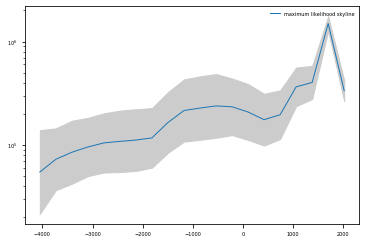

In [57]:
#treetime.wrappers.print_save_plot_skyline(tt, n_std=2.0, screen=True, save=False, plot=True)
out_path_skyline_pdf = os.path.join(outdir, SCRIPT_NAME + "_skyline.pdf" )
out_path_skyline_txt = os.path.join(outdir, SCRIPT_NAME + "_skyline.tsv" )

treetime.wrappers.print_save_plot_skyline(tt, 
                                          plot=out_path_skyline_pdf, 
                                          save=out_path_skyline_txt, 
                                          screen=True)

---
## Export

In [ ]:
# Save tree dataframe with clock info
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
tree_df.to_csv(out_path_df, sep="\t")

# Save timetree trees
out_path_xml = os.path.join(outdir, SCRIPT_NAME + ".xml" )
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )
Phylo.write(tt.tree, out_path_xml, 'phyloxml')
Phylo.write(tt.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
Phylo.write(tt.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))